In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, save_bundle, save_to_json

from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
tran_coef_before = np.array([4.28, 5.28, 5.33, 4.38, 4.13, 5.27, 5.28, 5.32, 5.15, 5.22, 4.46, 4.20, 5.17, 5.11, 4.91, 4.92, 4.87, 4.04, 4.32, 4.22 , 3.60, 2.88])
tran_coef_after = np.array([0.66 ,0.67 ,0.68 ,0.66 ,0.69 ,0.69 ,0.66 ,0.69 ,0.68 ,0.67 ,0.60 ,0.62 ,0.61 ,0.62 ,0.62 ,0.61 ,0.60 ,0.62 ,0.67 ,0.60 ,0.58 ,0.59 ,0.58 ,0.57 ,0.59 ,0.60 ,0.57 ])
infection_factor = np.mean(tran_coef_before) / np.mean(tran_coef_after)
infection_factor = np.log(infection_factor)
infection_factor

1.999881671966743

In [4]:
params_jan27 = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

In [5]:
params_jan27

total_population: 9000000
initial_num_E: 5000.0
initial_num_I: 5000
initial_num_M: 4000.0

alpha: 1.5999999999999998e-08
beta:  1.8e-09

mu_ei: 6
mu_mo: 10

x0_pt: 12000
k_pt:  0.00014931328910233792
mean_IM: 7

k_days: 14
        

In [6]:
lockdown_date = T('23/01/2020')
lockdown_date

datetime.datetime(2020, 1, 23, 0, 0)

In [7]:
target_E = params_jan27.initial_num_E
target_I = params_jan27.initial_num_I
target_M = params_jan27.initial_num_M

actual_I = np.array([target_I])
actual_E = np.array([target_E])
actual_M = np.array([target_M])

actual_E, actual_I, actual_M

(array([5000.]), array([5000]), array([4000.]))

In [11]:
def prepare_params(t):
    p = Params(
        alpha=[(0, infection_factor * params_jan27.alpha), (t, params_jan27.alpha)],
        beta=[(0, infection_factor * params_jan27.beta), (t, params_jan27.beta)],
        stages=[t],
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0,
        mu_ei=params_jan27.mu_ei,
        mu_mo=params_jan27.mu_mo,
        x0_pt=params_jan27.x0_pt,
        k_days=params_jan27.k_days
    )
    return p
        

In [12]:
bed_info = [(0, 3000)]
def one_run(t):
    params = prepare_params(t)
    # t days **before** lockdown (Jan 23)
    # simulation finishes at Jan 27 (after lockdown for 5 days)
    # t=1, 2, 3, ... means patient zero  appeared in Jan 22, 21, 20
    p0_time = lockdown_date - timedelta(days=t)
    
    total, _, _, _, stats = do_simulation(
        t+5, bed_info, params, p0_time=p0_time,
        verbose=0
    )
    
    pred_I = np.array([total[-1, STATE.I]])
    pred_E = np.array([total[-1, STATE.E]])
    pred_M = np.array([total[-1, STATE.M]])
    
    mse_I = mean_absolute_error(actual_I,  pred_I)
    mse_E = mean_absolute_error(actual_E, pred_E)
    mse_M = mean_absolute_error(actual_M, pred_M)
    mse_IM = mean_absolute_error(actual_M + actual_I, pred_M + pred_I)
    mse_IEM = mean_absolute_error(actual_I + actual_E + actual_M,  pred_I + pred_E + pred_M)
    return (t, actual_I[0], pred_I[0], mse_I, mse_E, mse_M, mse_IM, mse_IEM, stats)

In [13]:
# t is the number of days back
rows = Parallel(n_jobs=-1)(delayed(one_run)(t) for t in tqdm(range(30, 61)))

100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


In [14]:
df = pd.DataFrame(rows, columns=('t', 'actual_I', 'pred_I', 'mse_I', 'mse_E', 'mse_M', 'mse_IM', 'mse_IEM', 'r0_info'))

In [15]:
df.sort_values(by='mse_I').head(10)

,t,actual_I,pred_I,mse_I,mse_E,mse_M,mse_IM,mse_IEM,r0_info
23,53,5000,5044.748507,44.748507,1552.612290,1000.000000,955.251493,597.360797,"{'R0_by_stage': {0: (5.1215123171320585, 3.150..."
22,52,5000,3885.334894,1114.665106,558.921346,1062.156712,2176.821818,1617.900472,"{'R0_by_stage': {0: (5.121544198771868, 3.1398..."
24,54,5000,6687.138370,1687.138370,2731.283735,1201.733980,485.404390,3216.688125,"{'R0_by_stage': {0: (5.121466025584044, 3.1624..."
21,51,5000,3243.199885,1756.800115,283.687985,1455.399054,3212.199168,3495.887153,"{'R0_by_stage': {0: (5.121562154320443, 3.1307..."
20,50,5000,2712.188405,2287.811595,998.276604,1802.128329,4089.939924,5088.216527,"{'R0_by_stage': {0: (5.121566395321335, 3.1230..."
19,49,5000,2272.050067,2727.949933,1604.367105,2106.228703,4834.178636,6438.545741,"{'R0_by_stage': {0: (5.121556838562287, 3.1163..."
18,48,5000,1906.385945,3093.614055,2118.489290,2371.707795,5465.321850,7583.811140,"{'R0_by_stage': {0: (5.121533083188067, 3.1105..."
25,55,5000,8184.867009,3184.867009,4132.860163,1000.000000,2184.867009,6317.727172,"{'R0_by_stage': {0: (5.121404593397314, 3.1765..."
17,47,5000,1601.907769,3398.092231,2554.641722,2602.539226,6000.631457,8555.273178,"{'R0_by_stage': {0: (5.121494384772303, 3.1055..."
16,46,5000,1347.832039,3652.167961,2924.681901,2802.547335,6454.715296,9379.397197,"{'R0_by_stage': {0: (5.12143962412649, 3.10124..."


In [16]:
best_t = int(df.sort_values(by='mse_IM').iloc[0].t)
p0_time = T('22/01/2020') - timedelta(days=best_t)
print(p0_time)

2019-11-29 00:00:00


In [17]:
df.to_csv('output/tbl/p0-time/error.csv', index=False)

In [18]:
pkl.dump(p0_time, open('output/p0_time.pkl', 'wb'))

In [19]:
params = copy(params_jan27)
params.alpha = infection_factor * params.alpha
params.beta = infection_factor * params.beta
params.initial_num_E = 1
params.initial_num_I = 0
params.initial_num_M = 0

    
total, delta, increase, trans, stats = do_simulation(best_t, bed_info, params, verbose=0,  p0_time=p0_time)

In [20]:
save_bundle([total, delta, increase, trans], p0_time, best_t, 'output/tbl/before-lockdown')
save_to_json(stats, 'output/tbl/before-lockdown/stat.txt')

In [21]:
pkl.dump(
    params,
    open('output/params_before_lockdown.pkl', 'wb')
)

/home/cloud-user/code/covid-19/helpers.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['index'] = df.index
/home/cloud-user/code/covid-19/helpers.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['value'] = subdf[state].copy()
/home/cloud-user/code/covid-19/helpers.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

['29/11/19' '10/12/19' '21/12/19' '01/01/20' '12/01/20']


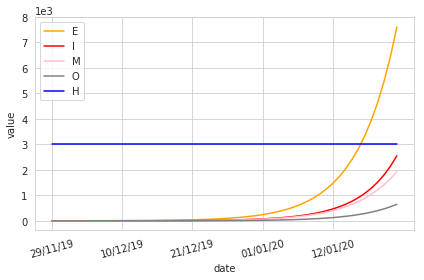

In [22]:
fig, ax = plot_total(total, p0_time, best_t)
fig.savefig('figs/before-lockdown.pdf')